In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
articles = pd.read_csv('articles.csv')
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

Data Preprocessing

Removing rows with null values

In [3]:
# Check for missing values
missing_values = articles.isnull().sum()
print("Missing Values in Each Column:\n", missing_values)
print("Number of rows before dropping null:", articles.shape[0])

Missing Values in Each Column:
 article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64
Number of rows before dropping null: 105542


In [4]:
articles.dropna(inplace=True)
print("Verifying clean dataset:\n", articles.isnull().sum())
print("Number of rows after dropping null:", articles.shape[0])

Verifying clean dataset:
 article_id                      0
product_code                    0
prod_name                       0
product_type_no                 0
product_type_name               0
product_group_name              0
graphical_appearance_no         0
graphical_appearance_name       0
colour_group_code               0
colour_group_name               0
perceived_colour_value_id       0
perceived_colour_value_name     0
perceived_colour_master_id      0
perceived_colour_master_name    0
department_no                   0
department_name                 0
index_code                      0
index_name                      0
index_group_no                  0
index_group_name                0
section_no                      0
section_name                    0
garment_group_no                0
garment_group_name              0
detail_desc                     0
dtype: int64
Number of rows after dropping null: 105126


Removing duplicated any rows

In [5]:
# Check for duplicates
duplicate_rows = articles.duplicated().sum()
print("\nNumber of duplicate rows:", duplicate_rows)


Number of duplicate rows: 0


In [6]:
# Remove duplicates in place
articles.drop_duplicates(inplace=True)
print("Number of rows after dropping duplicates:", articles.shape[0])

Number of rows after dropping duplicates: 105126


Reducing sample

In [7]:
import pandas as pd

# Define the target number of samples
target_sample_size = 15000

# Calculate the total number of products
total_products = len(articles)

# Determine the proportion of samples to take from each combination of product_type_name and colour_group_name
group_proportions = (
    articles.groupby(['product_type_name', 'colour_group_name'])
    .size()
    .reset_index(name='count')
)

# Calculate the number of samples to take from each group
group_proportions['samples'] = (group_proportions['count'] / total_products * target_sample_size).round().astype(int)

# Perform stratified sampling
def stratified_sample(group, n):
    return group.sample(n=n, random_state=42)

reduced_articles = (
    articles.groupby(['product_type_name', 'colour_group_name'])
    .apply(lambda x: stratified_sample(x, group_proportions.loc[(group_proportions['product_type_name'] == x.name[0]) &
                                                               (group_proportions['colour_group_name'] == x.name[1]), 'samples'].values[0]))
    .reset_index(drop=True)
)

# Verify the size of the reduced dataset
print(reduced_articles.shape)


(14840, 25)


In [8]:
reduced_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14840 entries, 0 to 14839
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   article_id                    14840 non-null  int64 
 1   product_code                  14840 non-null  int64 
 2   prod_name                     14840 non-null  object
 3   product_type_no               14840 non-null  int64 
 4   product_type_name             14840 non-null  object
 5   product_group_name            14840 non-null  object
 6   graphical_appearance_no       14840 non-null  int64 
 7   graphical_appearance_name     14840 non-null  object
 8   colour_group_code             14840 non-null  int64 
 9   colour_group_name             14840 non-null  object
 10  perceived_colour_value_id     14840 non-null  int64 
 11  perceived_colour_value_name   14840 non-null  object
 12  perceived_colour_master_id    14840 non-null  int64 
 13  perceived_colour

Data Exploration and Visualisation

<ipython-input-9-95484d7739f0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=reduced_articles, y='product_type_name', order=reduced_articles['product_type_name'].value_counts().index, palette='viridis')


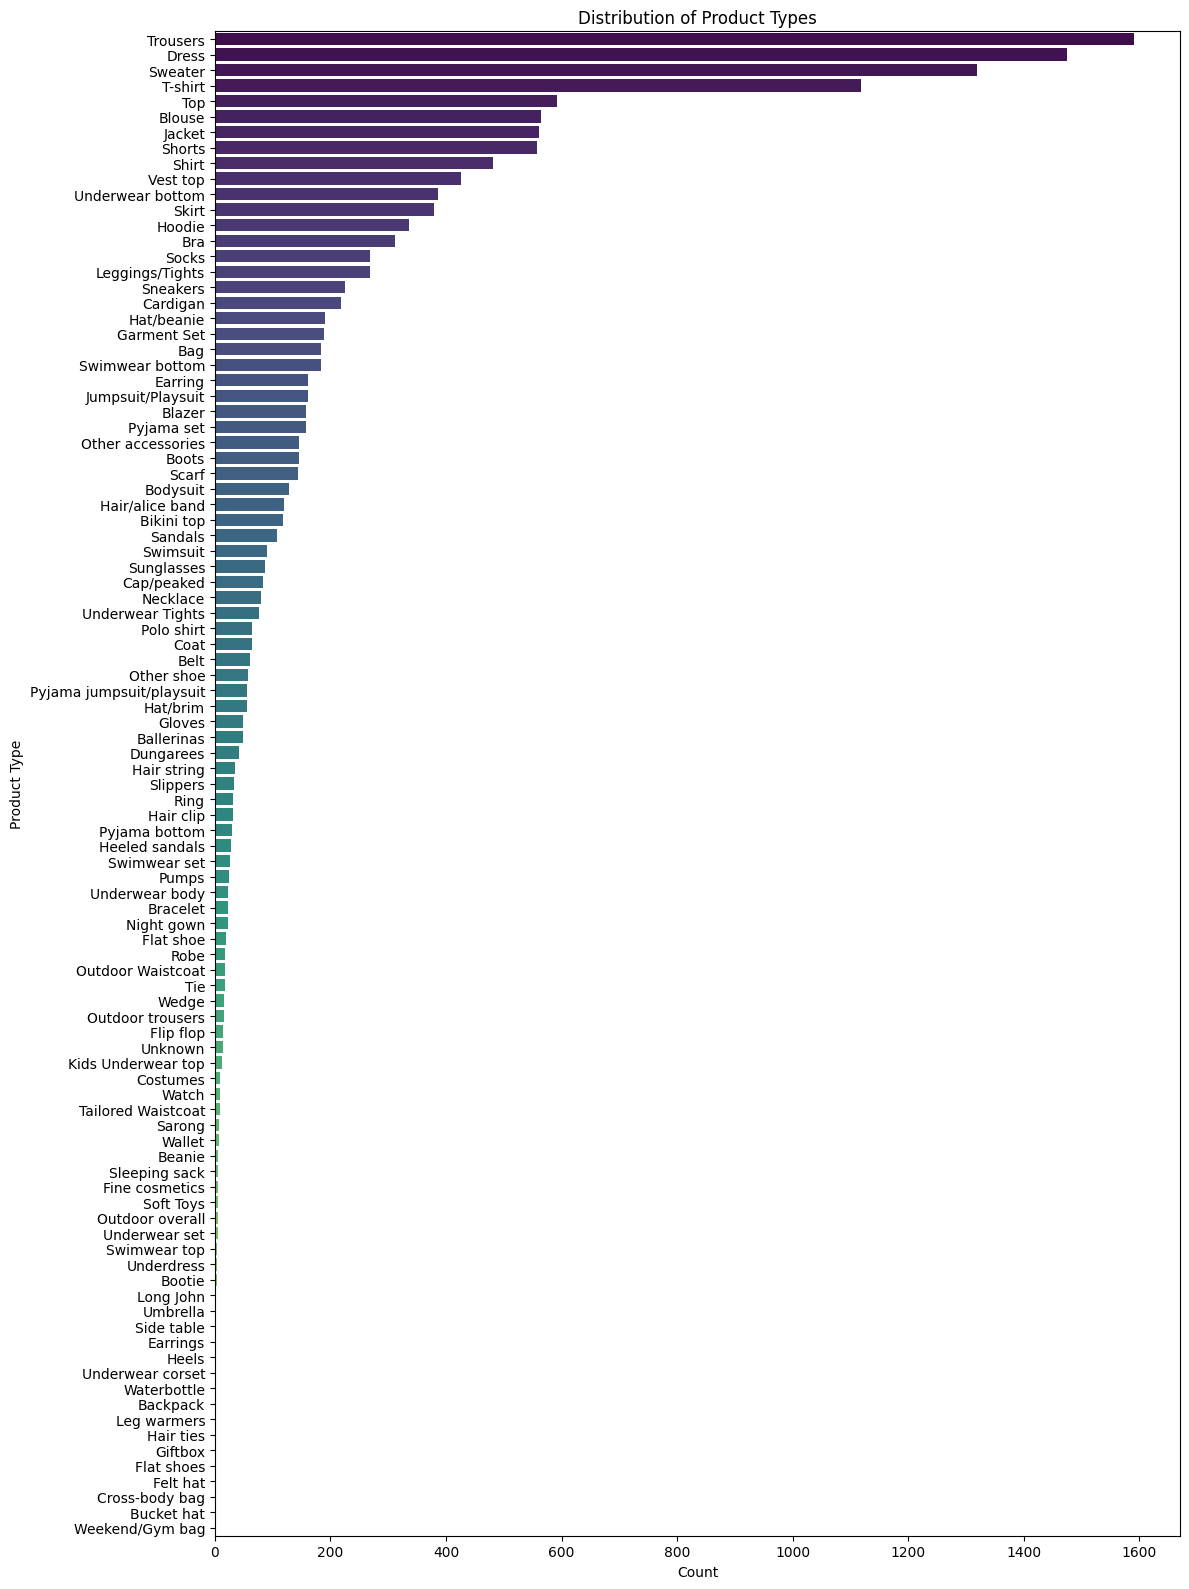

In [9]:
plt.figure(figsize=(12, 16))  # Increased height
sns.countplot(data=reduced_articles, y='product_type_name', order=reduced_articles['product_type_name'].value_counts().index, palette='viridis')
plt.title('Distribution of Product Types')
plt.xlabel('Count')
plt.ylabel('Product Type')
plt.tight_layout()
plt.show()


<ipython-input-10-9fa8658e99ef>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=reduced_articles, y='colour_group_name', order=reduced_articles['colour_group_name'].value_counts().index, palette='magma')


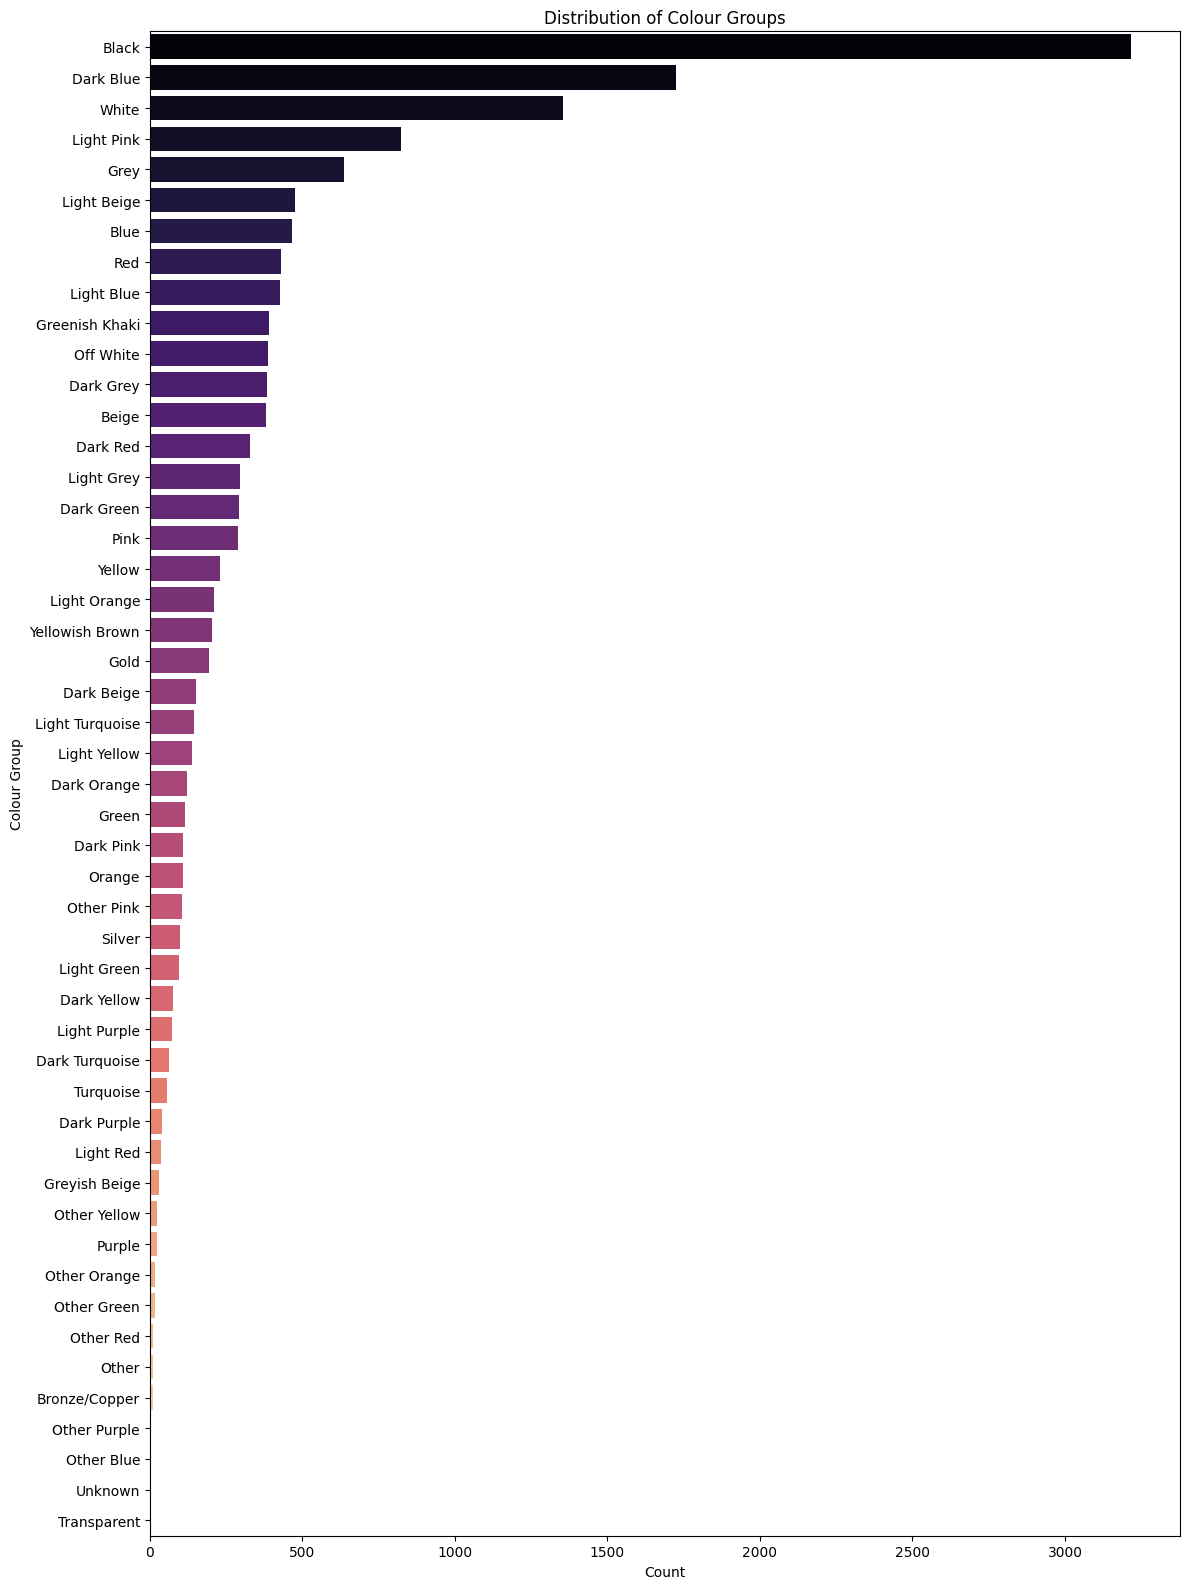

In [10]:
plt.figure(figsize=(12, 16))  # Increased height
sns.countplot(data=reduced_articles, y='colour_group_name', order=reduced_articles['colour_group_name'].value_counts().index, palette='magma')
plt.title('Distribution of Colour Groups')
plt.xlabel('Count')
plt.ylabel('Colour Group')
plt.tight_layout()
plt.show()


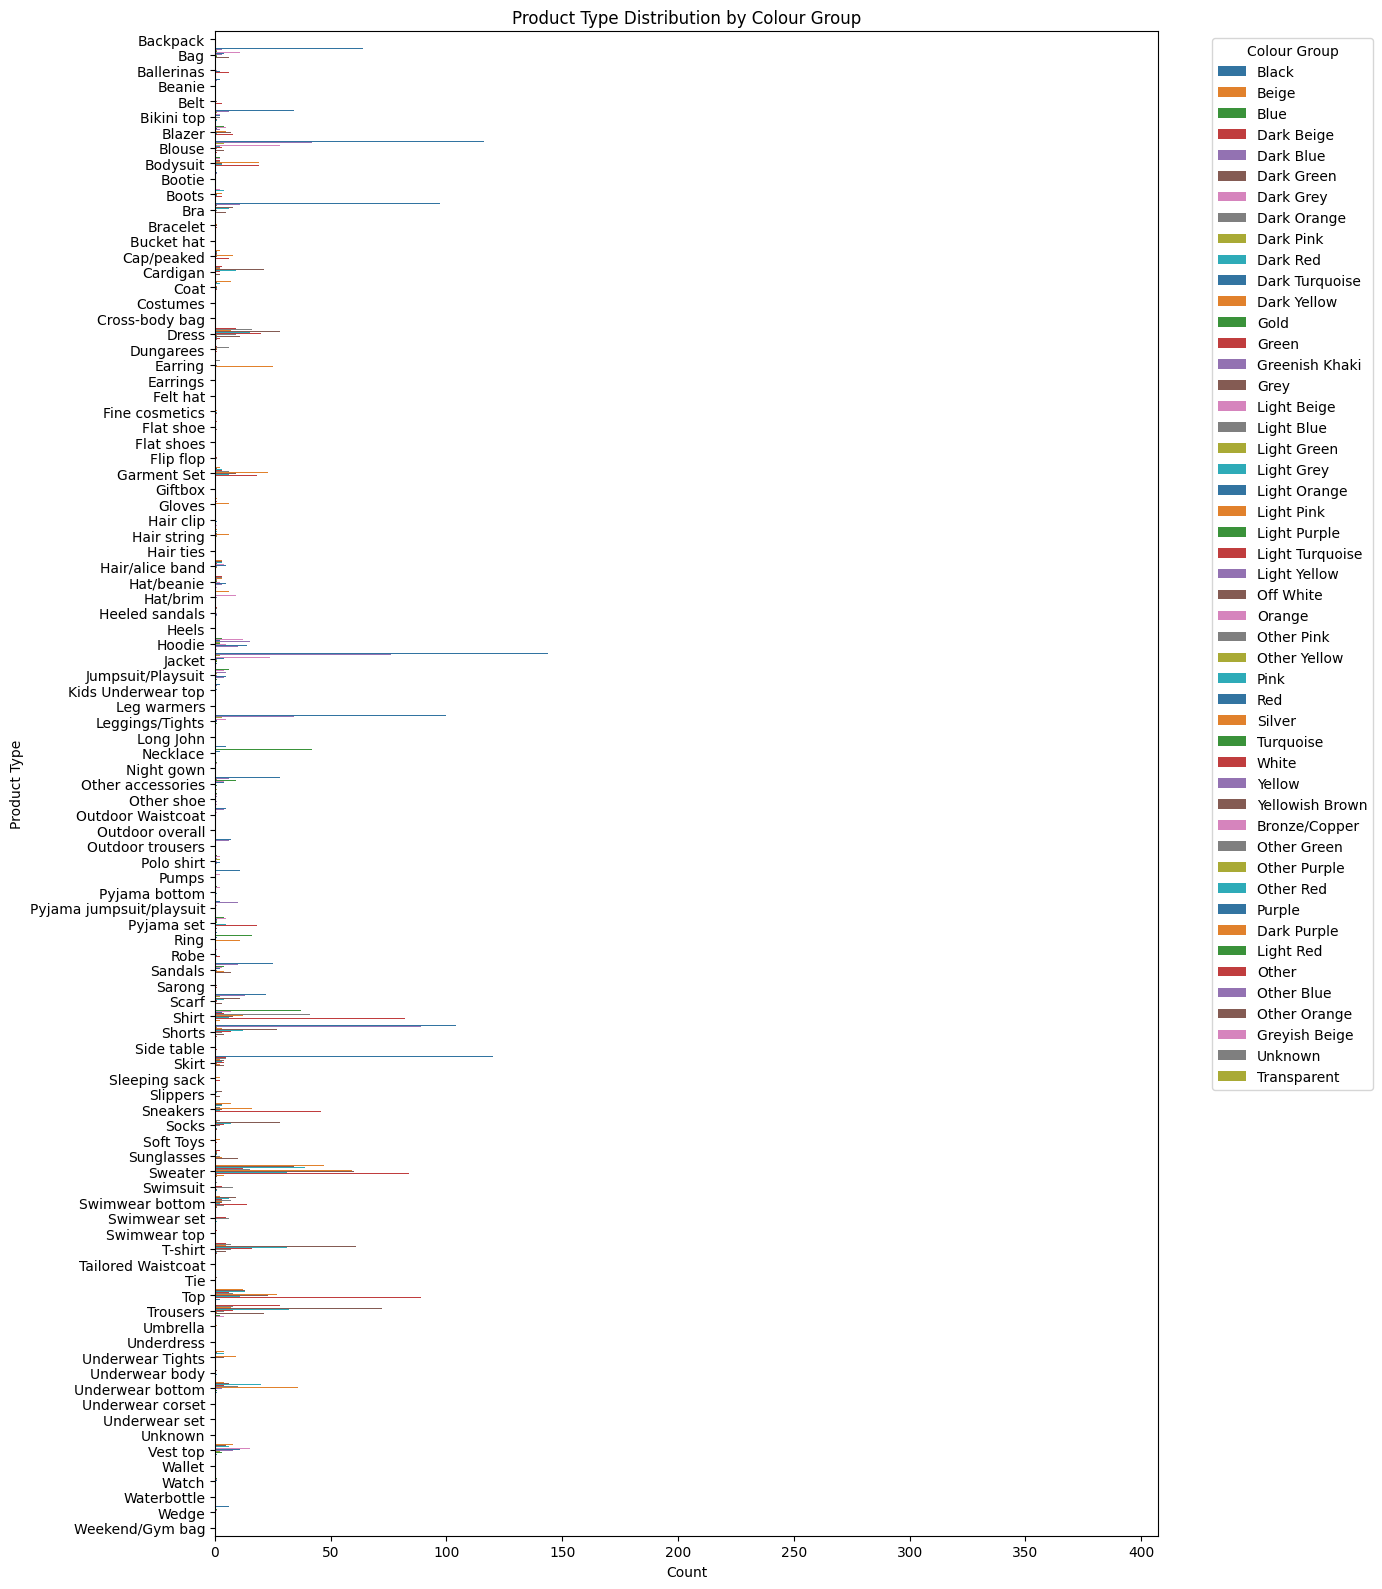

In [11]:
plt.figure(figsize=(14, 16))  # Increased height
sns.countplot(data=reduced_articles, y='product_type_name', hue='colour_group_name', palette='tab10')
plt.title('Product Type Distribution by Colour Group')
plt.xlabel('Count')
plt.ylabel('Product Type')
plt.legend(title='Colour Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-12-f80f25f7ca4e>:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


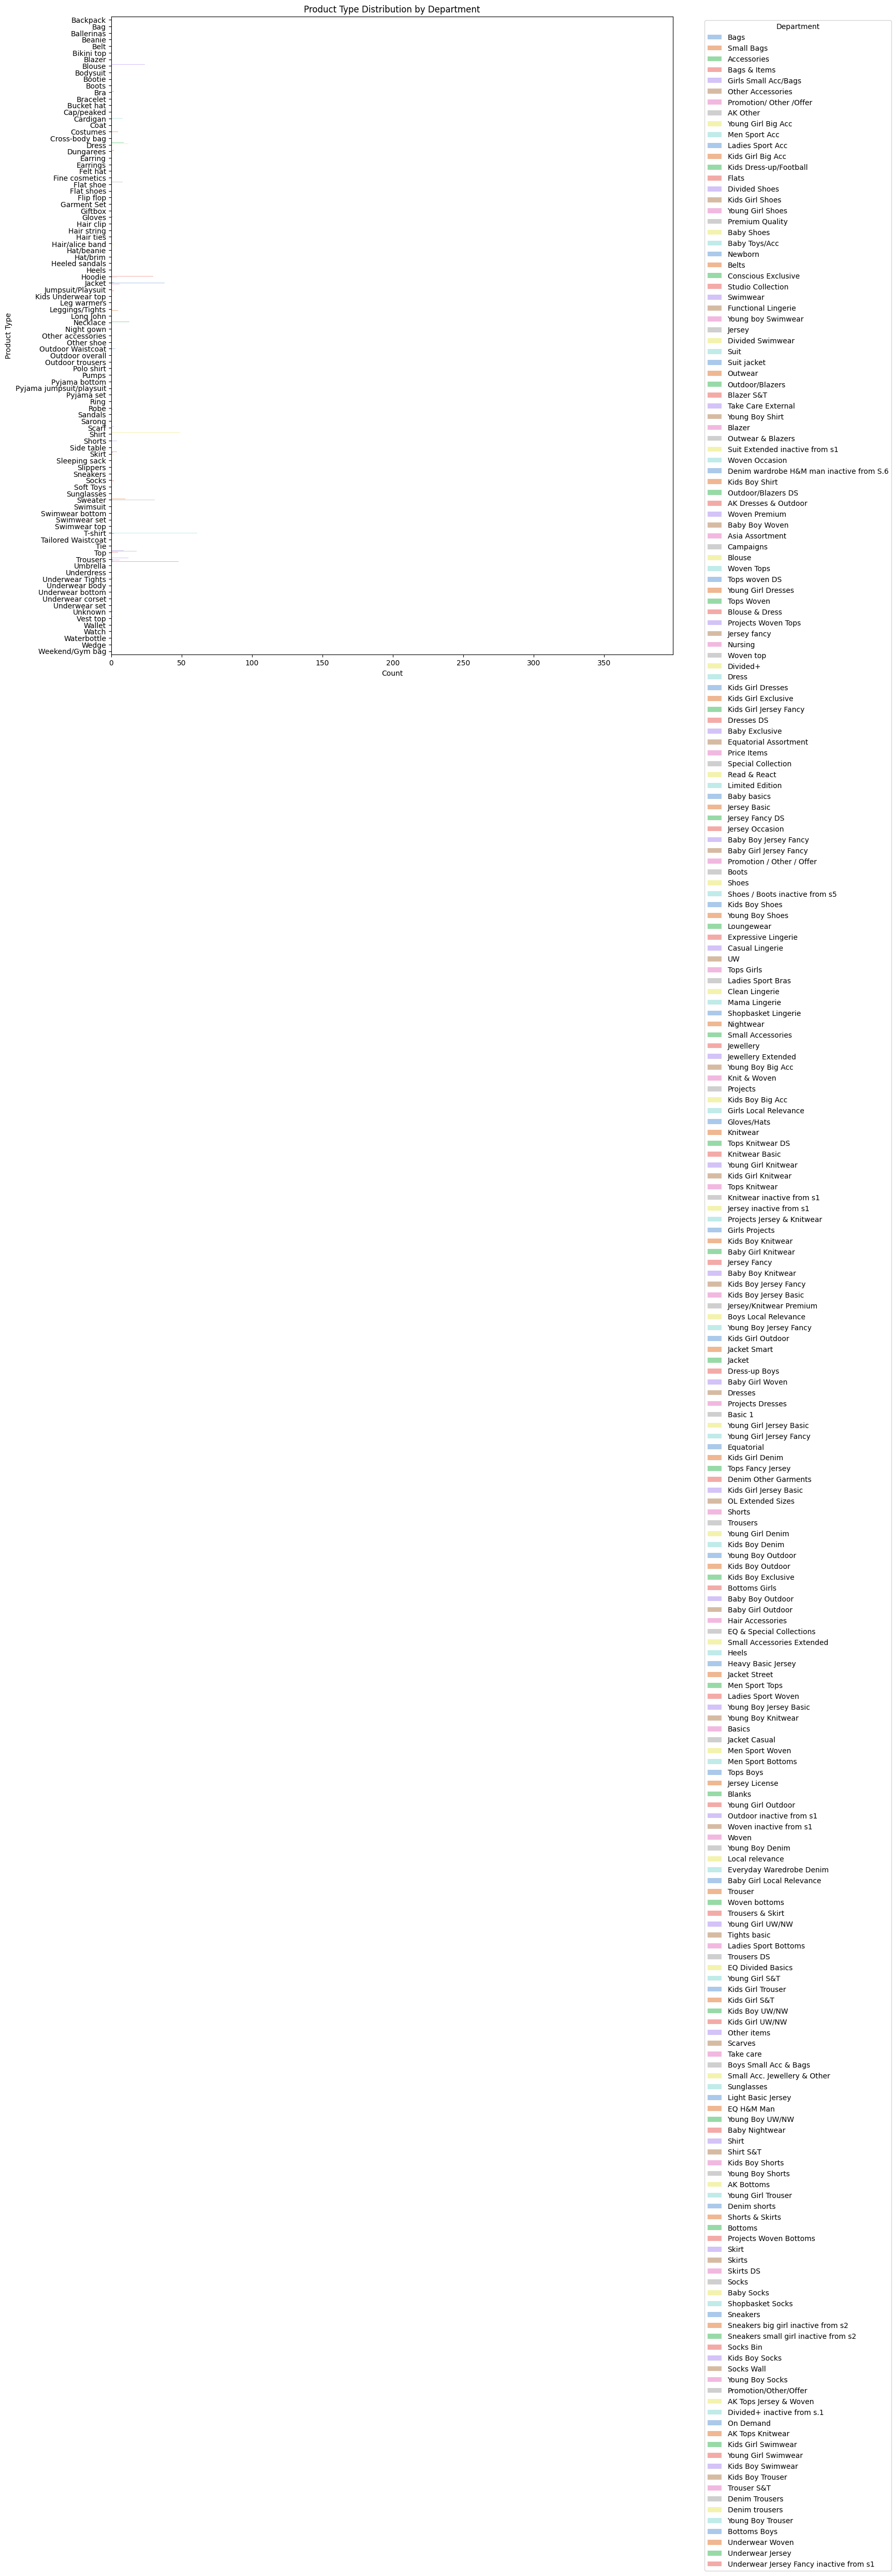

In [12]:
plt.figure(figsize=(14, 16))  # Increased height
sns.countplot(data=reduced_articles, y='product_type_name', hue='department_name', palette='pastel')
plt.title('Product Type Distribution by Department')
plt.xlabel('Count')
plt.ylabel('Product Type')
plt.legend(title='Department', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<ipython-input-13-94258708f0bb>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=reduced_articles, y='garment_group_name', order=reduced_articles['garment_group_name'].value_counts().index, palette='inferno')


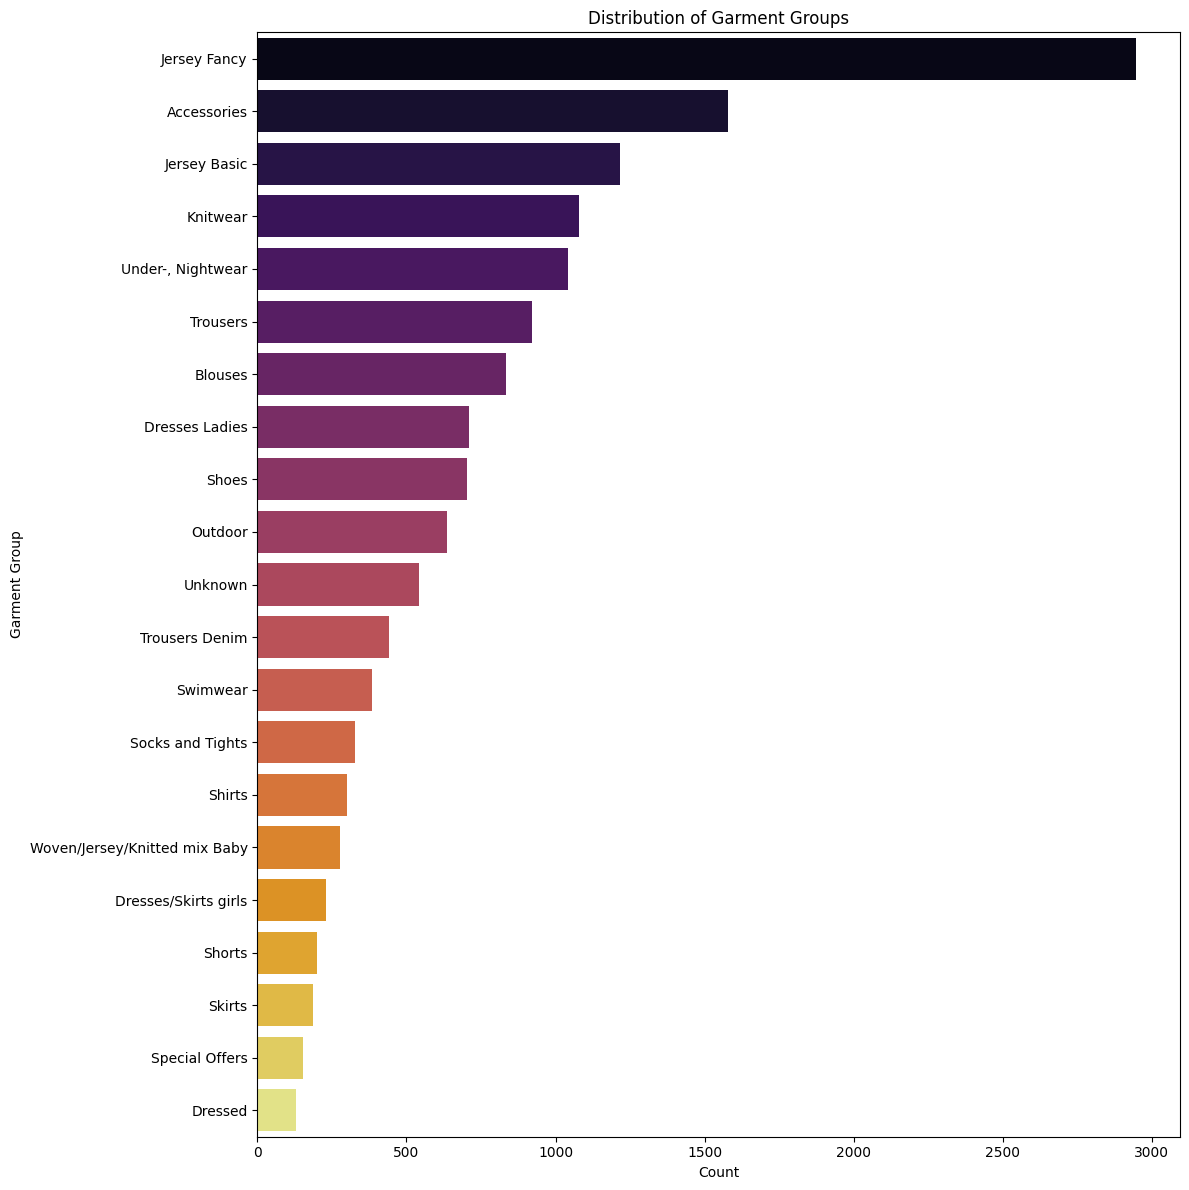

In [13]:
plt.figure(figsize=(12, 12))  # Increased height
sns.countplot(data=reduced_articles, y='garment_group_name', order=reduced_articles['garment_group_name'].value_counts().index, palette='inferno')
plt.title('Distribution of Garment Groups')
plt.xlabel('Count')
plt.ylabel('Garment Group')
plt.tight_layout()
plt.show()


<Figure size 1400x1000 with 0 Axes>

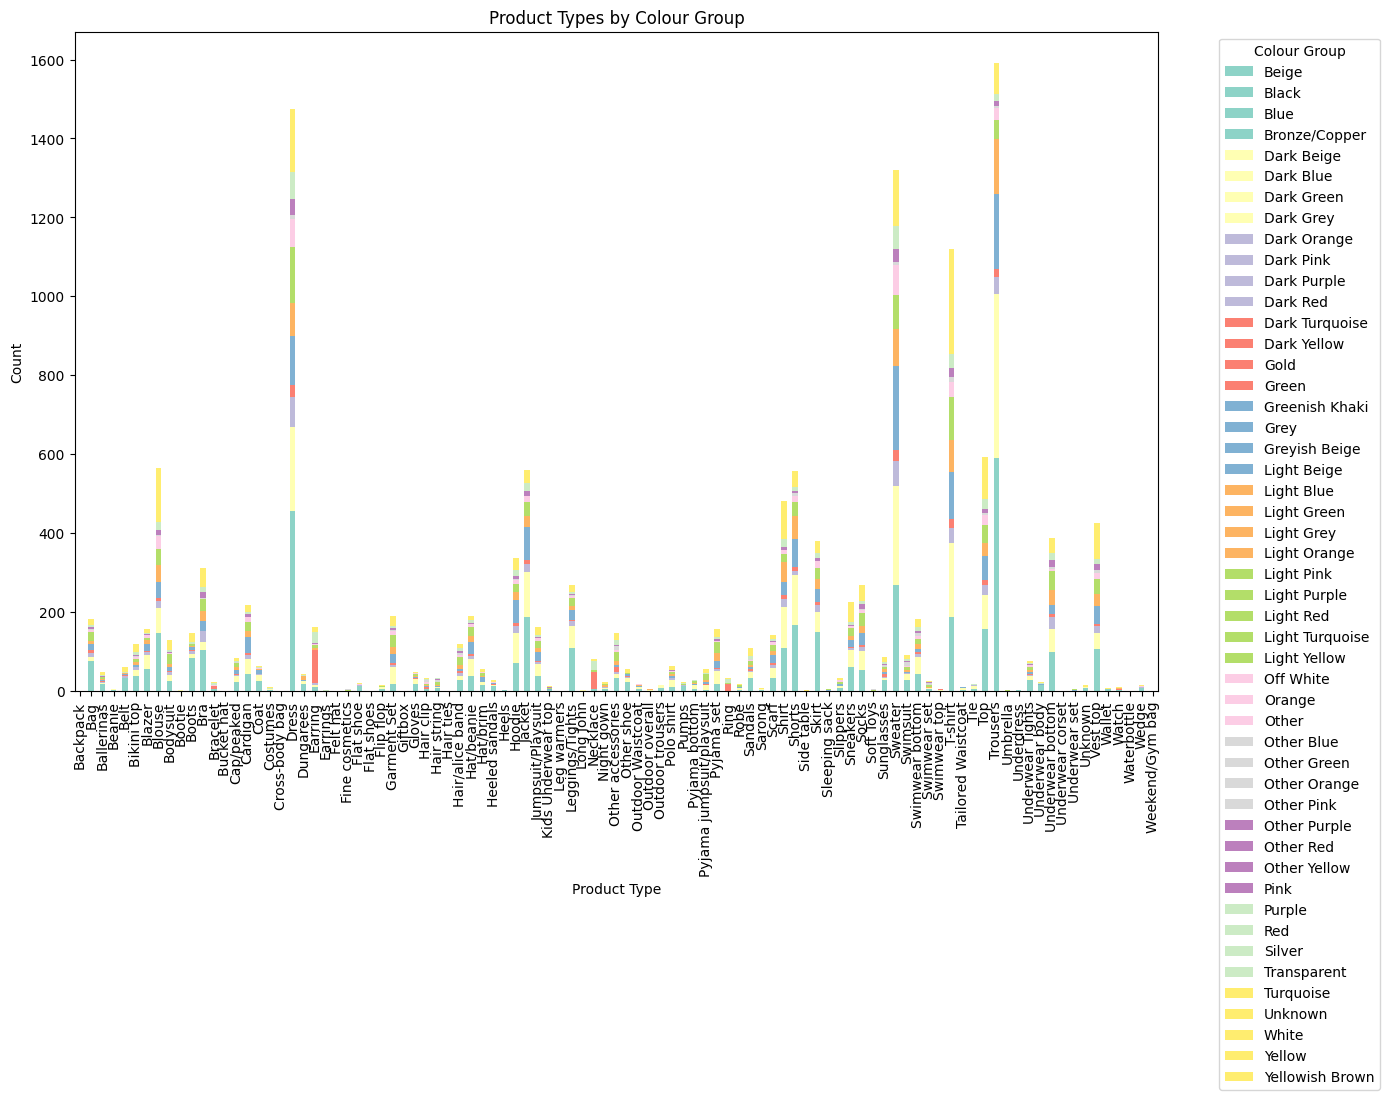

In [14]:
plt.figure(figsize=(14, 10))
product_colours = pd.crosstab(reduced_articles['product_type_name'], reduced_articles['colour_group_name'])
product_colours.plot(kind='bar', stacked=True, colormap='Set3', figsize=(14, 10))
plt.title('Product Types by Colour Group')
plt.xlabel('Product Type')
plt.ylabel('Count')
plt.legend(title='Colour Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-15-ffbfa6201b0e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=availability_counts.values, y=availability_counts.index, palette='dark')


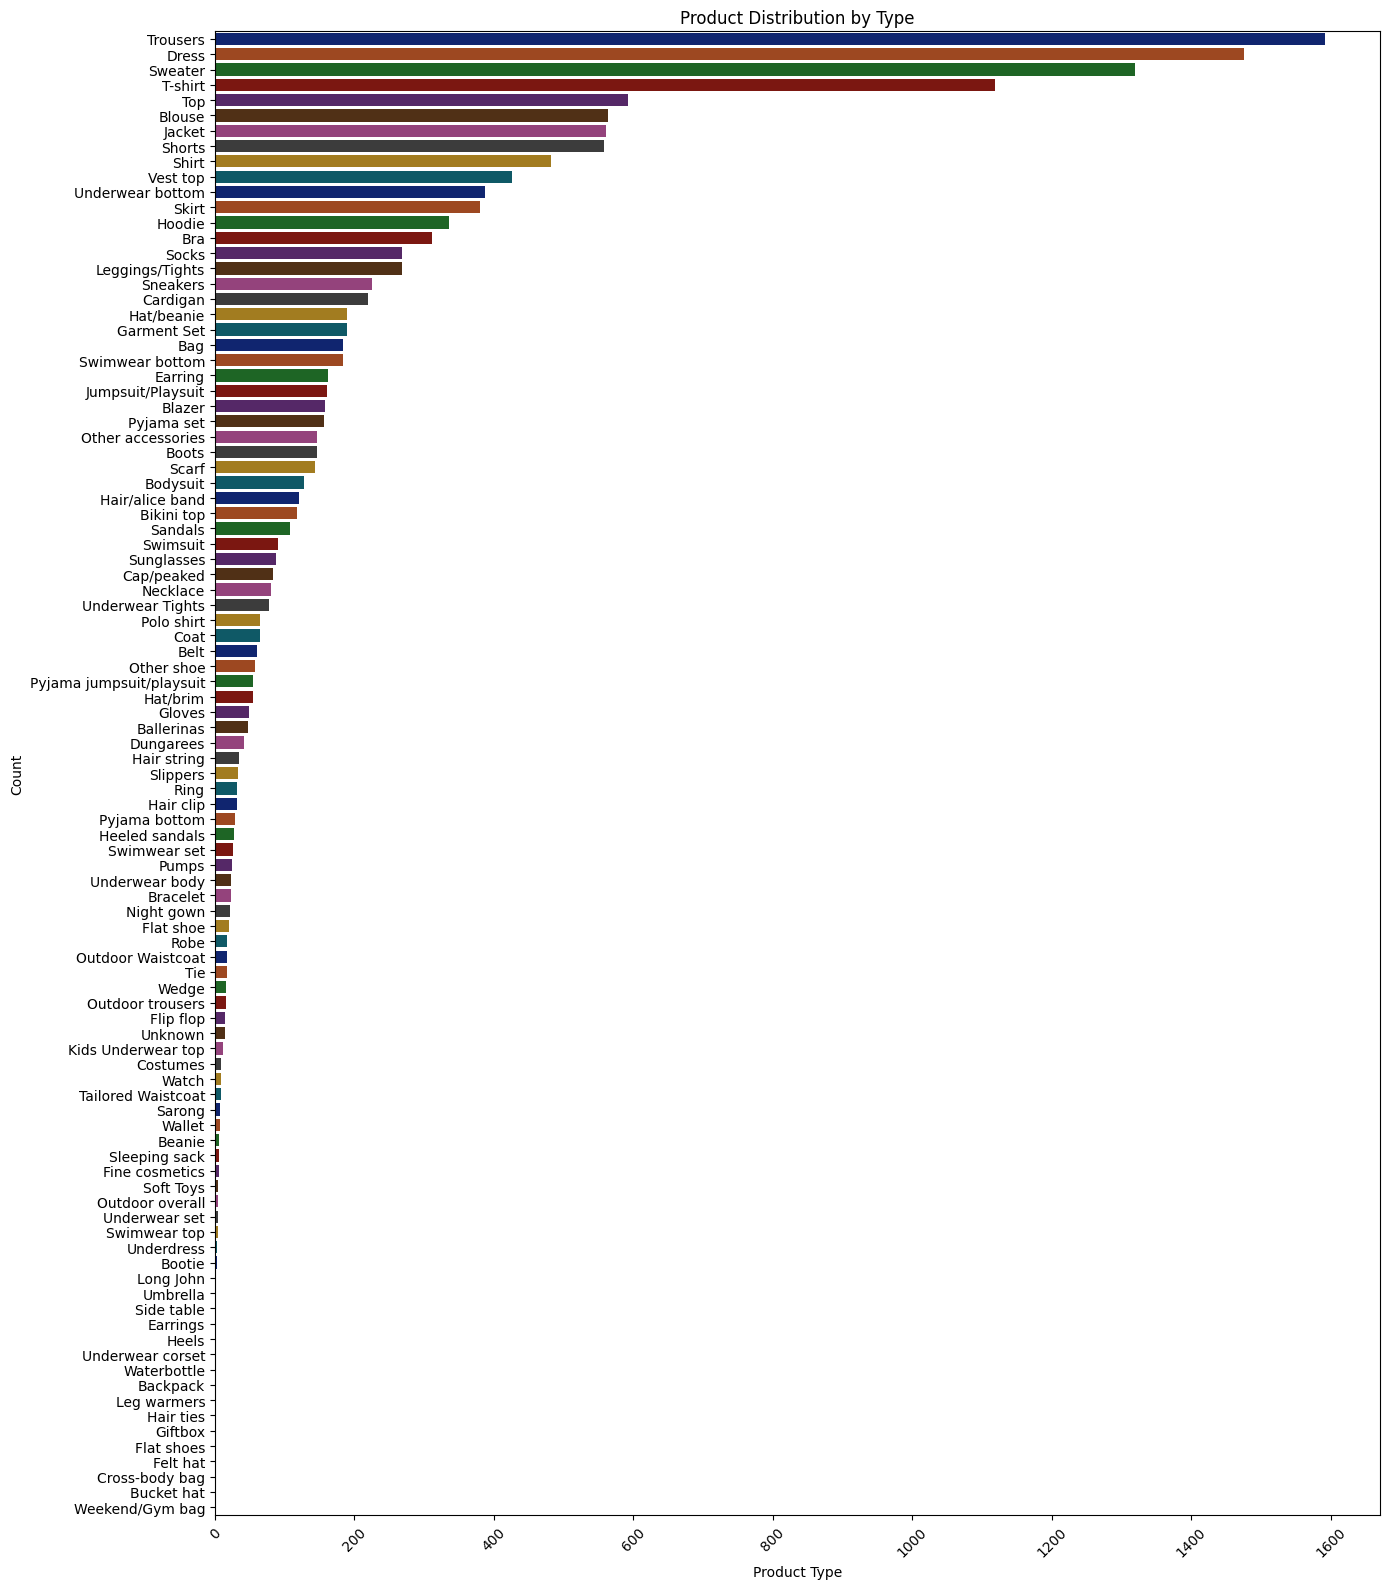

In [15]:
plt.figure(figsize=(14, 16))
availability_counts = reduced_articles['product_type_name'].value_counts()
sns.barplot(x=availability_counts.values, y=availability_counts.index, palette='dark')
plt.title('Product Distribution by Type')
plt.xlabel('Product Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

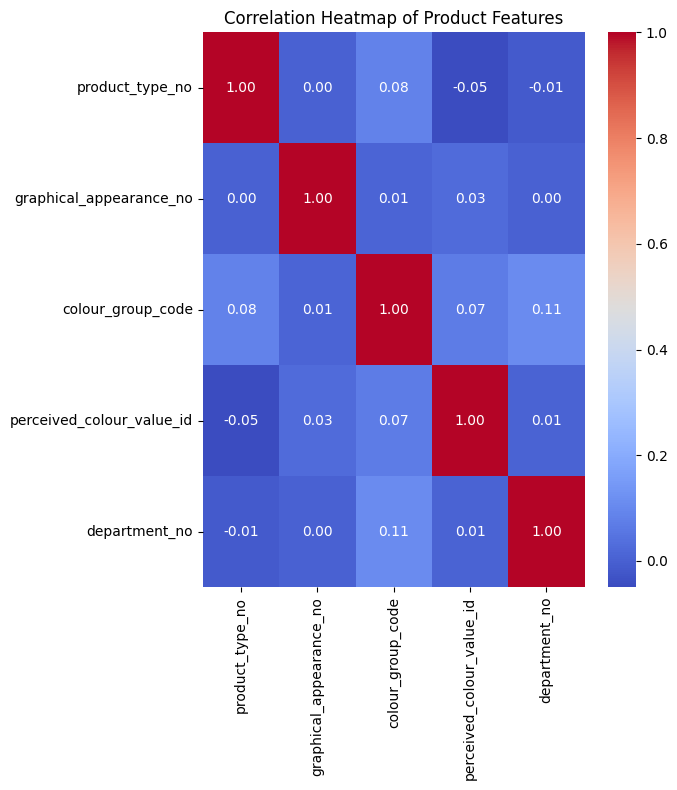

In [16]:
plt.figure(figsize=(7, 8))
corr_matrix = reduced_articles[['product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id', 'department_no']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Product Features')
plt.tight_layout()
plt.show()

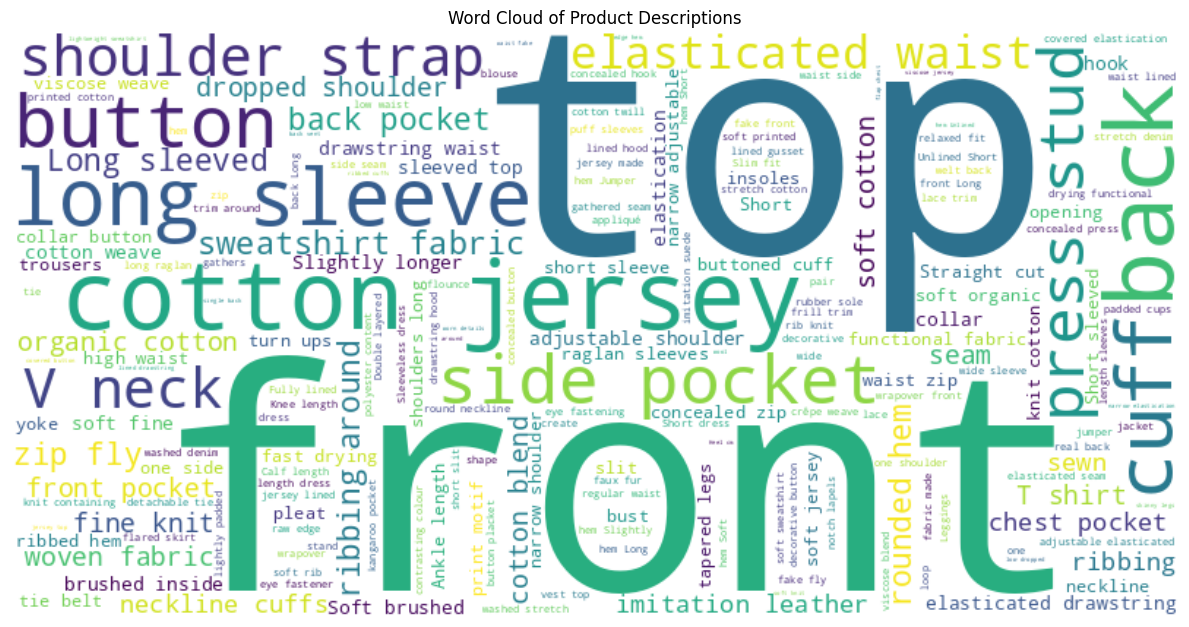

In [17]:
from wordcloud import WordCloud
plt.figure(figsize=(12, 12))
text = ' '.join(reduced_articles['detail_desc'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Product Descriptions')
plt.axis('off')
plt.tight_layout()
plt.show()


Encoding categorical variables

In [18]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Select features for recommendation
features = ['product_type_name', 'product_group_name', 'graphical_appearance_name',
            'colour_group_name', 'perceived_colour_value_name',
            'perceived_colour_master_name', 'department_name', 'index_name',
            'index_group_name', 'section_name', 'garment_group_name']

# Perform one-hot encoding on the selected features
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(reduced_articles[features])

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(features))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Computing cosine similarity

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(encoded_df, encoded_df)


Creating product recommendations

In [20]:
import numpy as np

def recommend_products(product_id, similarity_matrix, articles_df, top_n=5):
    # Get the index of the product_id
    idx = articles_df.index[articles_df['article_id'] == product_id].tolist()[0]

    # Get the similarity scores for this product
    similarity_scores = similarity_matrix[idx]

    # Get the indices of the top_n most similar products
    similar_indices = similarity_scores.argsort()[::-1][1:top_n+1]  # Skip the first one as it is the product itself

    # Get the recommended product details
    input_product = articles_df.iloc[idx]
    recommended_products = articles_df.iloc[similar_indices]

    # Print the input product
    print("Input Product:")
    print(input_product[['article_id', 'prod_name', 'product_type_name', 'colour_group_name']])

    return recommended_products[['article_id', 'prod_name', 'product_type_name', 'colour_group_name']]

In [21]:
# Example: Recommend products similar to a specific product_id
product_id = reduced_articles.iloc[0]['article_id']  # Choose a product to start with
recommended_products = recommend_products(product_id, similarity_matrix, reduced_articles, top_n=5)

# Print the recommendations

print("\nRecommended Products:")
print(recommended_products)

Input Product:
article_id                    682238003
prod_name            NAV MINI BACK PACK
product_type_name              Backpack
colour_group_name                 Black
Name: 0, dtype: object

Recommended Products:
       article_id          prod_name product_type_name colour_group_name
14839   753475001      MINDY SHOPPER   Weekend/Gym bag             Black
51      701735016       ETTA BUM BAG               Bag             Black
66      468977001     Selena Shopper               Bag             Black
29      706890001  NAV MINI BACKPACK               Bag             Black
43      912820001   OLIVIA BACK PACK               Bag             Black


In [22]:
# Example: Recommend products similar to a specific product_id
product_id = reduced_articles.iloc[1000]['article_id']  # Choose a product to start with
recommended_products = recommend_products(product_id, similarity_matrix, reduced_articles, top_n=5)

# Print the recommendations

print("\nRecommended Products:")
print(recommended_products)

Input Product:
article_id           562637001
prod_name                Sandy
product_type_name       Blouse
colour_group_name          Red
Name: 1000, dtype: object

Recommended Products:
     article_id      prod_name product_type_name colour_group_name
998   595386007         Bouqet            Blouse               Red
997   855076002          Daisy            Blouse               Red
992   596344001          Grebo            Blouse               Red
993   627197003    Gaby Blouse            Blouse               Red
985   633825004  Julius blouse            Blouse               Red


In [28]:
# Example: Recommend products similar to a specific product_id
product_id = reduced_articles.iloc[14000]['article_id']  # Choose a product to start with
recommended_products = recommend_products(product_id, similarity_matrix, reduced_articles, top_n=5)

# Print the recommendations

print("\nRecommended Products:")
print(recommended_products)

Input Product:
article_id                        874169001
prod_name            Wayne 3p Coolmax Trunk
product_type_name          Underwear bottom
colour_group_name                     Black
Name: 14000, dtype: object

Recommended Products:
       article_id                   prod_name product_type_name  \
14000   874169001      Wayne 3p Coolmax Trunk  Underwear bottom   
14096   575447005             Chris 7pk Basic  Underwear bottom   
14062   571520001               Max Dark Xmas  Underwear bottom   
14077   645477001                 Raymond 3pk  Underwear bottom   
14022   662369017  MAX CHECKS AND STRIPES 3PK  Underwear bottom   

      colour_group_name  
14000             Black  
14096         Dark Blue  
14062             Black  
14077         Dark Blue  
14022             Black  


In [24]:
# Example: Recommend products similar to a specific product_id
product_id = reduced_articles.iloc[100]['article_id']  # Choose a product to start with
recommended_products = recommend_products(product_id, similarity_matrix, reduced_articles, top_n=5)

# Print the recommendations

print("\nRecommended Products:")
print(recommended_products)

Input Product:
article_id              736631003
prod_name            Bag Jalle BP
product_type_name             Bag
colour_group_name     Dark Yellow
Name: 100, dtype: object

Recommended Products:
    article_id              prod_name product_type_name colour_group_name
56   697982001  Kent Rubber Zipper BP               Bag             Black
18   681595001        Tech L Backpack               Bag             Black
57   880260001              Bag Luigi               Bag             Black
60   615181001         Buster bum bag               Bag             Black
64   732873001      Bag Simon Rolltop               Bag             Black
